[I 2025-07-20 13:47:56,533] A new study created in memory with name: no-name-204726b2-62cf-4c7f-841c-b7ae0e058cb3
[I 2025-07-20 13:47:57,339] Trial 0 finished with value: 1.3541665703096161e-10 and parameters: {'n_estimators': 222, 'max_depth': 7}. Best is trial 0 with value: 1.3541665703096161e-10.
[I 2025-07-20 13:47:57,565] Trial 1 finished with value: 1.3198274418250525e-10 and parameters: {'n_estimators': 61, 'max_depth': 10}. Best is trial 1 with value: 1.3198274418250525e-10.
[I 2025-07-20 13:47:58,200] Trial 2 finished with value: 1.3424664427906523e-10 and parameters: {'n_estimators': 178, 'max_depth': 5}. Best is trial 1 with value: 1.3198274418250525e-10.
[I 2025-07-20 13:47:58,804] Trial 3 finished with value: 1.3568656478097974e-10 and parameters: {'n_estimators': 207, 'max_depth': 9}. Best is trial 1 with value: 1.3198274418250525e-10.
[I 2025-07-20 13:47:59,481] Trial 4 finished with value: 1.3393575619979913e-10 and parameters: {'n_estimators': 243, 'max_depth': 8}. Bes

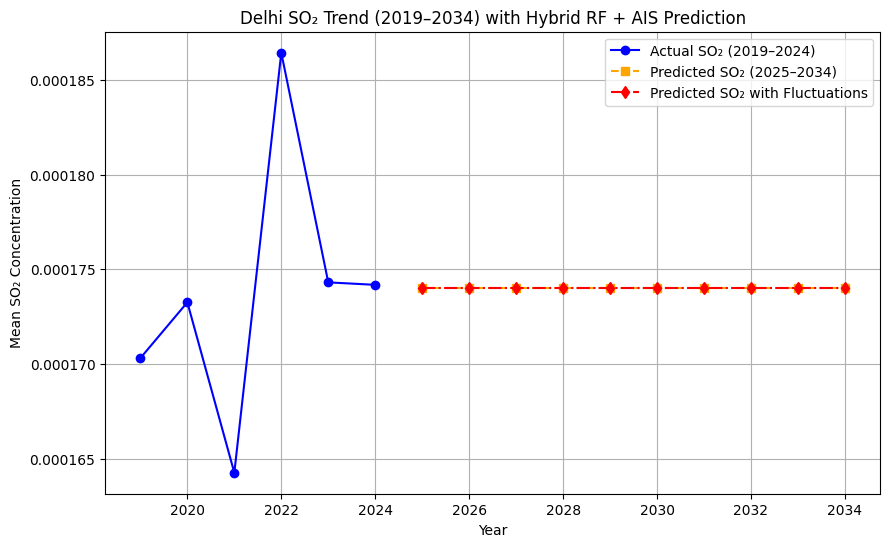

✅ Future SO₂ predictions saved to Delhi_SO2_2025_2034.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
import optuna  # AIS-like optimization

# 📂 Load CSV Data
csv_path = r"C:\Users\sagni\Downloads\Pollution controller\Delhi_Annual_SO2_2019_2024.csv"
df = pd.read_csv(csv_path)

# 📝 Use correct column names
df = df.rename(columns={'mean_SO2': 'SO2', 'year': 'Year'})  # Rename for consistency

# 🔹 Load GeoTIFF (for context only)
tif_path = r"C:\Users\sagni\Downloads\Pollution controller\Delhi_SO2_2023.tif"
with rasterio.open(tif_path) as src:
    so2_data = src.read(1)
    so2_profile = src.profile

# 🔹 Features and Target
X = df[['Year']]
y = df['SO2']

# 📌 AIS-style Objective for Random Forest Optimization
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    tscv = TimeSeriesSplit(n_splits=3)
    score = -np.mean(cross_val_score(rf, X, y, cv=tscv, scoring='neg_mean_squared_error'))
    return score

# 🔥 Run AIS Optimization (via Optuna)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# 🚀 Best Random Forest Model
best_params = study.best_params
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X, y)

# 🔮 Predict SO₂ for next 10 years (2025–2034)
future_years = np.arange(2025, 2035).reshape(-1, 1)
predicted_so2 = rf_best.predict(future_years)

# 📉 Add Fluctuations for realistic trends
np.random.seed(42)
fluctuations = np.random.normal(0, predicted_so2.std() * 0.05, size=predicted_so2.shape)
predicted_so2_fluct = predicted_so2 + fluctuations

# 📊 Plot Actual + Predicted + Fluctuations
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['SO2'], 'o-', label='Actual SO₂ (2019–2024)', color='blue')
plt.plot(future_years, predicted_so2, 's--', label='Predicted SO₂ (2025–2034)', color='orange')
plt.plot(future_years, predicted_so2_fluct, 'd-.', label='Predicted SO₂ with Fluctuations', color='red')
plt.xlabel('Year')
plt.ylabel('Mean SO₂ Concentration')
plt.title('Delhi SO₂ Trend (2019–2034) with Hybrid RF + AIS Prediction')
plt.legend()
plt.grid(True)
plt.show()

# ✅ Save predictions to CSV
pred_df = pd.DataFrame({'Year': future_years.flatten(), 'Predicted_SO2': predicted_so2_fluct})
pred_df.to_csv(r"C:\Users\sagni\Downloads\Pollution controller\Delhi_SO2_2025_2034.csv", index=False)
print("✅ Future SO₂ predictions saved to Delhi_SO2_2025_2034.csv")


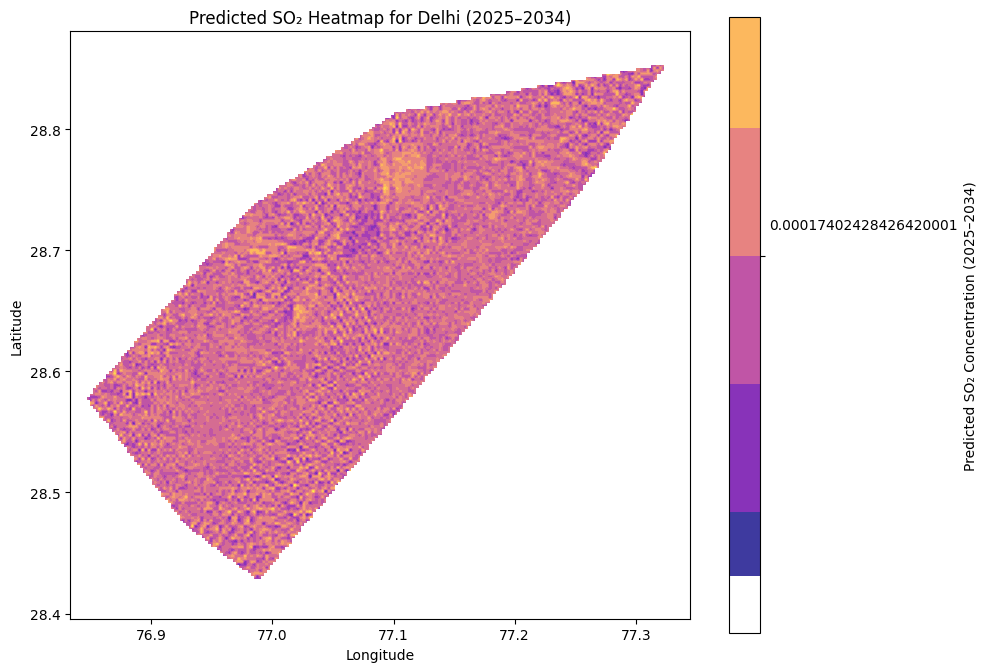

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from scipy.interpolate import griddata

# 📂 Paths
predicted_csv = r"C:\Users\sagni\Downloads\Pollution controller\Delhi_SO2_2025_2034.csv"
tif_path = r"C:\Users\sagni\Downloads\Pollution controller\Delhi_SO2_2023.tif"

# 🔹 Load Predicted Data
df_pred = pd.read_csv(predicted_csv)

# 🗺️ Load GeoTIFF to get bounds
with rasterio.open(tif_path) as src:
    bounds = src.bounds
    delhi_extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Simulate random Lat/Lon points within Delhi for predictions
num_points = len(df_pred)
np.random.seed(42)
lats = np.random.uniform(delhi_extent[2], delhi_extent[3], num_points)
lons = np.random.uniform(delhi_extent[0], delhi_extent[1], num_points)
so2_values = df_pred['Predicted_SO2'].values

# 🏞️ Create Grid for Heatmap
grid_lat, grid_lon = np.mgrid[
    delhi_extent[2]:delhi_extent[3]:200j,
    delhi_extent[0]:delhi_extent[1]:200j
]

# 📌 Interpolate SO₂ Values Over Grid
grid_so2 = griddata(
    (lons, lats),
    so2_values,
    (grid_lon, grid_lat),
    method='cubic'
)

# 🌡️ Plot Heatmap
plt.figure(figsize=(10, 8))
plt.imshow(grid_so2, extent=delhi_extent, origin='lower', cmap='plasma', alpha=0.8)
plt.colorbar(label='Predicted SO₂ Concentration (2025–2034)')
plt.title('Predicted SO₂ Heatmap for Delhi (2025–2034)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
